# Stream Data from a .csv 

In [1]:
import sys
import os
import time
import matplotlib.pyplot as plt
# from scipy.signal import butter, filtfilt, lfilter
from scipy import signal
import numpy as np
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler

In [2]:
import sys
sys.path.append("..") # So that it can find the modules
# Assuming the other modules (brainflow_stream, filtering, segmentation, classification) are available
from modules.brainflow_stream import *
from modules.filtering import *
from modules.segmentation import *
from modules.classification import *
from modules.ssvep_stim import *

from modules.visualization import *

In [3]:
# Setting variables:
board_id = BoardIds.CYTON_BOARD.value # BoardIds.SYNTHETIC_BOARD.value 
frequencies = [9.25, 11.25, 13.25, 15.25]
buttons = ['Right', 'Left', 'Up', 'Down']
button_pos = [0, 2, 3, 1]
display = 0
segment_duration = 3

# Static Variables - Probably don't need to touch :)
harmonics = 3 # np.arange(1, 4) # Generates the 1st, 2nd, & 3rd Harmonics
sampling_rate = BoardShim.get_sampling_rate(board_id)
n_samples = sampling_rate * segment_duration

In [4]:
# Initialize Streaming Board
board = BrainFlowBoardSetup(board_id = BoardIds.PLAYBACK_FILE_BOARD.value,
                            file = '../120s_cyton_recording.csv', # ~120s recording where participant looked at each stimulus for 15 seconds before switching clock-wise to the next
                            master_board = BoardIds.CYTON_BOARD.value )
board.setup()

# board.board_config('/2')

# Let data accumulate
time.sleep(15)

raw_data = board.get_current_board_data(num_samples = n_samples)
eeg_data = raw_data[1:9, :] # Removing the timestamp column
eeg_data.shape
# board.stop()

[Board 0, ] Board setup and streaming started successfully.


(8, 750)

In [5]:
timestamps = raw_data[22, :]
package_nums = raw_data[0]

In [6]:
filter_obj = Filtering(sampling_rate)

filtered_data = filter_obj.bandpass_filter(eeg_data, highcut=30, lowcut=5)

channel_names = board.get_eeg_names(board_id=board_id)

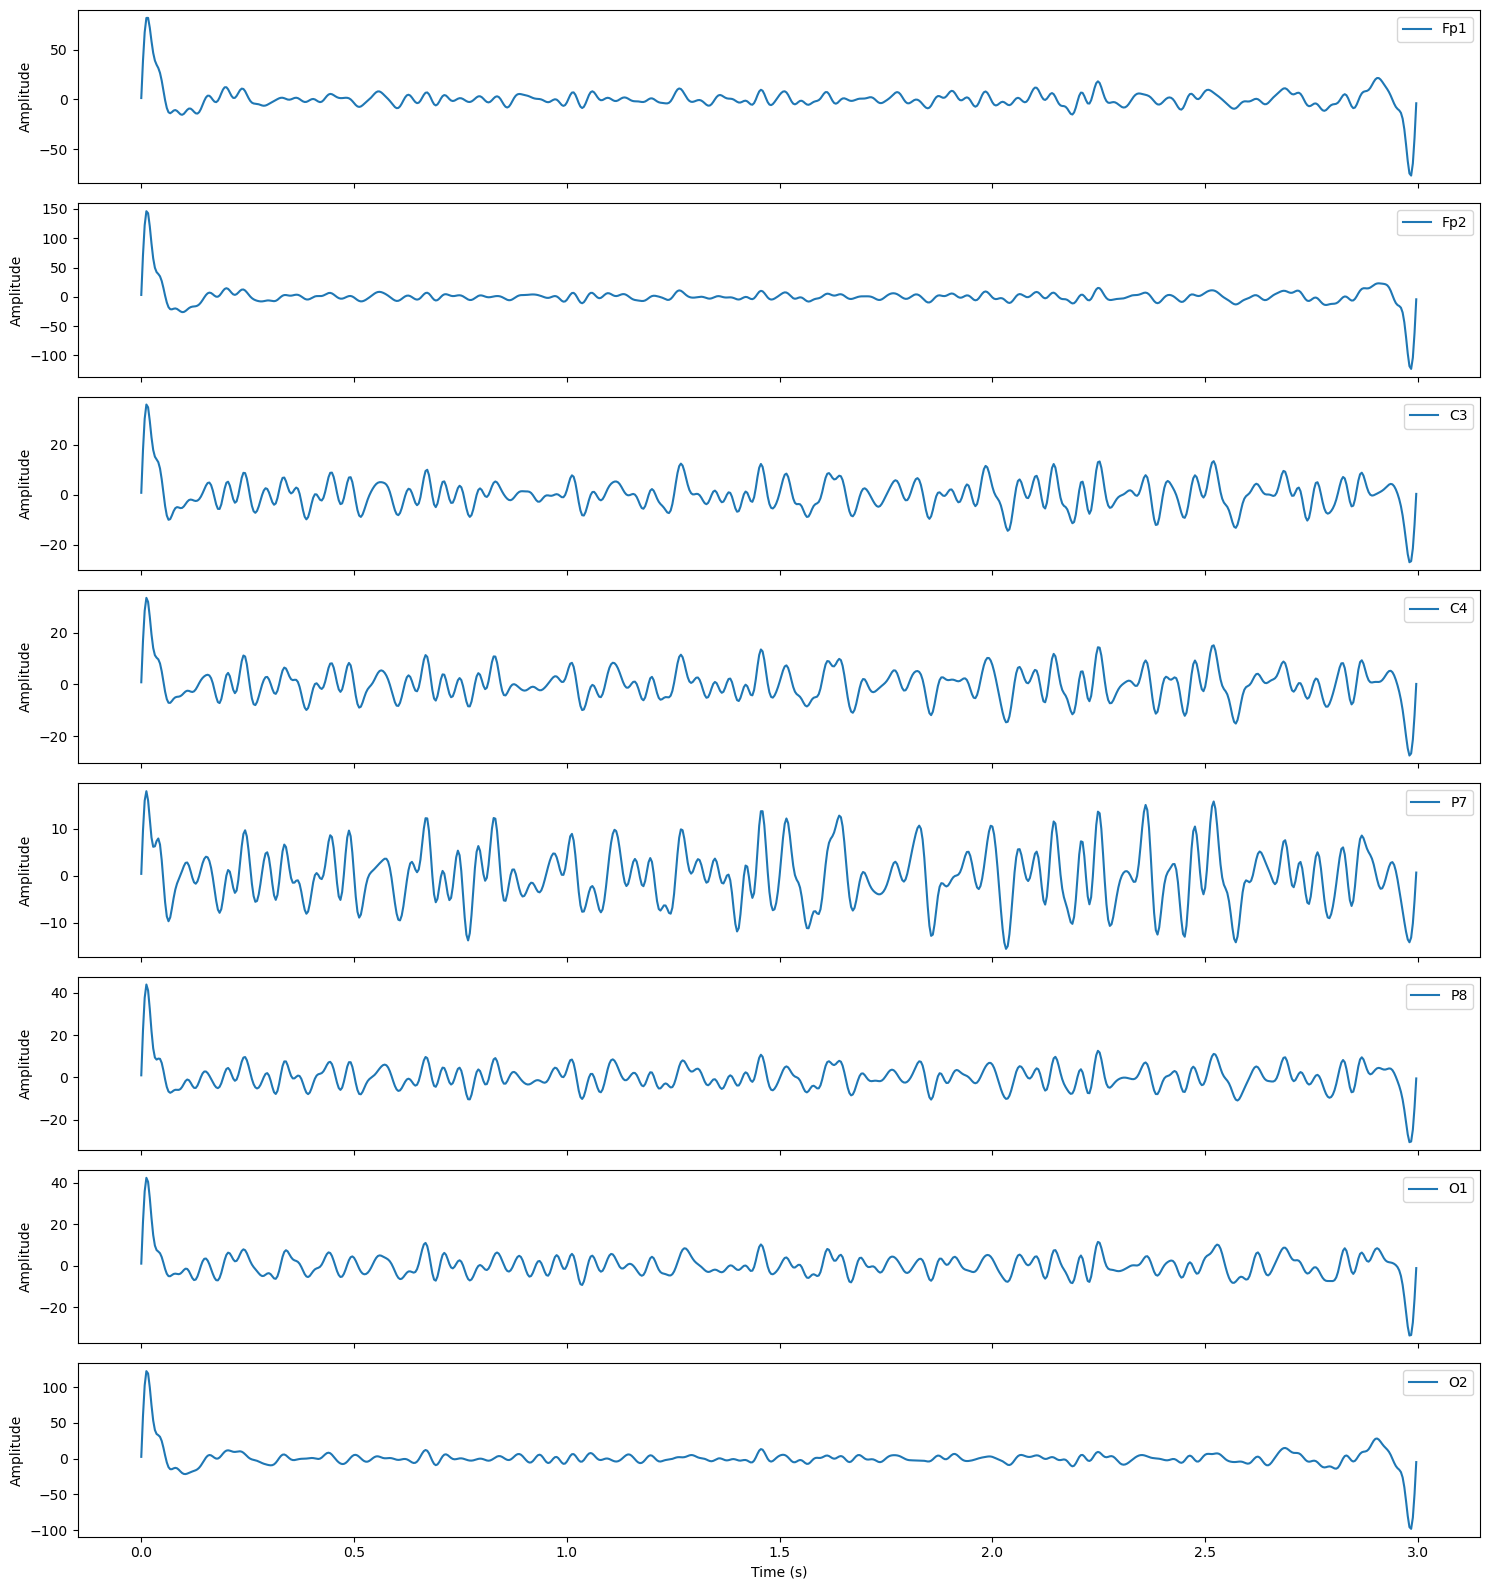

In [7]:
plot_eeg_time_series(filtered_data, sampling_rate, channel_names = channel_names)

c:\Users\surge\miniforge3\envs\stealthneuro\lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 1024 is greater than input length  = 750, using nperseg = 750
  warnings.warn('nperseg = {0:d} is greater than input length '


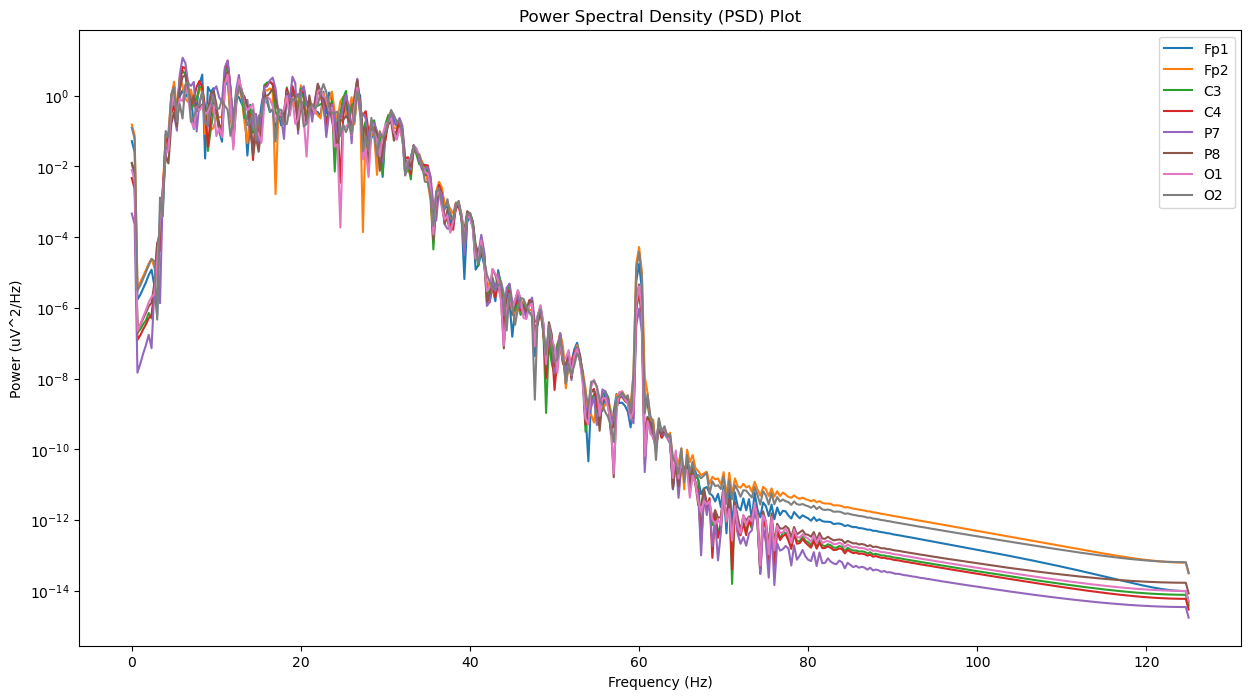

In [8]:
plot_psd(filtered_data, sampling_rate, channel_names = channel_names)

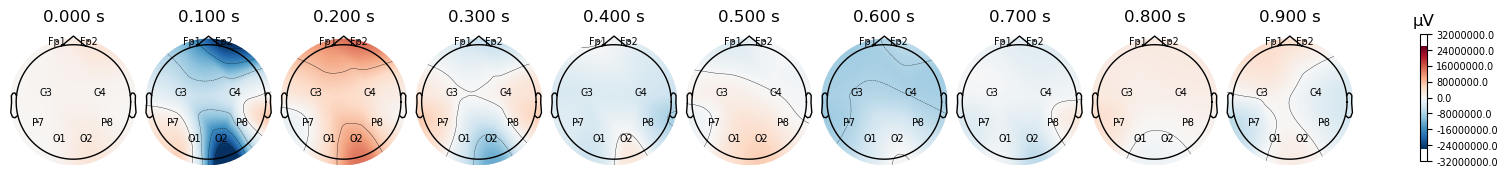

In [11]:
plot_topomap(filtered_data, channel_names = channel_names, sampling_rate=sampling_rate,
             times = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

### Reference code from `Pipeline_Test_Suite_STREAM_DATA.py`

In [ ]:
# Initialize Streaming Board
board = BrainFlowBoardSetup(board_id = BoardIds.PLAYBACK_FILE_BOARD.value,
                            file = '120s_cyton_recording.csv', # ~120s recording where participant looked at each stimulus for 15 seconds before switching clock-wise to the next
                            master_board = BoardIds.CYTON_BOARD.value )
board.setup()

actual_freqs = [9.23, 11.43, 13.33, 15.0] # Actual stim freqs when recording the data
print("Actual Frequencies:", actual_freqs)

# cca_classifier = SSVEPClassifier(frequencies=actual_freqs, 
#                                 harmonics=harmonics, 
#                                 sampling_rate=sampling_rate, 
#                                 n_samples=n_samples, 
#                                 method='CCA', 
#                                 stack_harmonics=True)

cca_classifier = SSVEPClassifier(freqs=actual_freqs, 
                                    win_len=segment_duration, 
                                    s_rate=sampling_rate)

filter_obj = Filtering(sampling_rate)

time.sleep(15)

while True:
    segment = board.get_current_board_data(num_samples=n_samples)
    eeg_segment = segment[1:9, :]  # Channels 1-9 are EEG channels
    
    dc_offset_removed = remove_dc_offset(eeg_segment)
            
    # Apply bandpass filter
    filtered_segment = filter_obj.bandpass_filter(dc_offset_removed, highcut=30, lowcut=0.1, order=4)

    r = cca_classifier.apply_cca(filtered_segment.T) 
    print(r)
    
    # visualize_all_channels_plotly(eeg_segment, filtered_segment)
    
    # Check signal alignment for the first frequency
    # reference_signal = cca_classifier.reference_signals[0]  # First frequency reference
    # check_signal_alignment(filtered_segment, reference_signal)

    # Compare one EEG channel (Channel 1) against reference signal for the first frequency
    # visualize_reference_vs_eeg(filtered_segment, reference_signal, actual_freqs[0])
    
    

    # Perform classification using the filtered EEG data
    # correlations = []
    # for freq_idx, freq in enumerate(actual_freqs):
    #     detected_freq, correlation = cca_classifier(filtered_segment)
    #     correlations.append(correlation)
    #     print(f"Frequency: {freq} Hz, Correlation: {correlation}")

    # Plot correlation coefficients across frequencies (optional, uncomment if needed)
    # plot_correlation_across_frequencies(actual_freqs, correlations)
    


    # Wait for the next segment of data
    time.sleep(segment_duration)